# Installing Dependencies

In [1]:
!pip install mlflow==2.11.1 pynvml psutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.7.0
    Uninstalling importlib_metadata

# Imports

In [2]:
# --- IMPORTS ---

# Standard Libraries
import os
import time
import copy
import zipfile

# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.amp import GradScaler, autocast
import numpy as np

# Visualization and Progress
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Experiment Tracking
import mlflow
import mlflow.pytorch
import mlflow.system_metrics
import mlflow.data

from mlflow.data.meta_dataset import MetaDataset
from mlflow.data.http_dataset_source import HTTPDatasetSource
from mlflow.types import Schema, ColSpec, DataType

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Configs

In [3]:
# --- 1. MASTER CONFIGURATION BLOCK ---
# Change parameters here for each new experiment

# --- MLflow Configuration ---
EXPERIMENT_NAME = "Pneumonia Classification"
RUN_TAG = "Full Run - 20 Epochs" # Descriptive tag for this group of runs

# --- Model Selection ---
MODELS_TO_TRAIN = [
    'resnet50',
    'resnext50', 
    'efficientnet_v2_s', 
    'convnext_tiny', 
    'vit_b_16',
    'swin_t'
]

# --- Dataset Configuration ---
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# --- Training Hyperparameters ---
NUM_EPOCHS = 20
BATCH_SIZE = 16

# --- Optimizer Configuration ---
OPTIMIZER_TYPE = 'AdamW' # Options: 'AdamW', 'Adam', 'SGD'
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-2

# --- Loss Function Configuration ---
LOSS_FUNCTION_TYPE = 'weighted'

# --- Learning Rate Scheduler Configuration ---
SCHEDULER_TYPE = 'cosine'

# Data Handling

## Dataset Metadata

In [4]:
DATA_SOURCE = HTTPDatasetSource(
    url="https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"
)

# Option 1: Simple metadata dataset
META_DATASET = MetaDataset(source=DATA_SOURCE, name="chest-xray-pneumonia")

# Option 2: With schema information
DATASET_SCHEMA = Schema(
    [
        ColSpec(type=DataType.string, name="text"),
        ColSpec(type=DataType.integer, name="label"),
    ]
)

META_DATA_W_SCHEMA = MetaDataset(
    source=DATA_SOURCE, name="chest-xray-pneumonia", schema=DATASET_SCHEMA
)


## Dataset Transformation

In [5]:
# --- 2. DATA LOADING & TRANSFORMATION ---

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Classes: {class_names}")
print(f"Using device: {device}")

Classes: ['NORMAL', 'PNEUMONIA']
Using device: cuda:0


## Data Loading

In [6]:
# Create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Training data size: {dataset_sizes['train']}")
print(f"Validation data size: {dataset_sizes['val']}")

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Classes: ['NORMAL', 'PNEUMONIA']
Training data size: 5216
Validation data size: 16
Using device: cuda:0


# Helper Functions

## Model Loading

In [7]:
def get_model(model_name, num_classes):
    """Loads a pretrained model and replaces the final layer."""
    model = None
    if model_name == 'resnet50':
        model = models.resnet50(weights='DEFAULT')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnext50':
        model = models.resnext50_32x4d(weights='DEFAULT')
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'efficientnet_v2_s':
        model = models.efficientnet_v2_s(weights='DEFAULT')
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(weights='DEFAULT')
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'convnext_tiny':
        model = models.convnext_tiny(weights='DEFAULT')
        num_ftrs = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'swin_t':
        model = models.swin_t(weights='DEFAULT')
        num_ftrs = model.head.in_features
        model.head = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Model name '{model_name}' not recognized.")
    return model.to(device)

## Training Function

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    scaler = torch.amp.GradScaler("cuda")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_val_preds, best_val_labels = None, None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}'); print('-' * 10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            epoch_labels, epoch_preds = [], []
            
            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.amp.autocast(device_type="cuda"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                if phase == 'train':
                    scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                epoch_labels.extend(labels.cpu().numpy()); epoch_preds.extend(preds.cpu().numpy())
                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss); history['train_acc'].append(epoch_acc.item())
                mlflow.log_metric("train_loss", epoch_loss, step=epoch)
                mlflow.log_metric("train_acc", epoch_acc.item(), step=epoch)
            else:
                history['val_loss'].append(epoch_loss); history['val_acc'].append(epoch_acc.item())
                mlflow.log_metric("val_loss", epoch_loss, step=epoch)
                mlflow.log_metric("val_acc", epoch_acc.item(), step=epoch)
                val_precision = precision_score(epoch_labels, epoch_preds, average='macro', zero_division=0)
                val_recall = recall_score(epoch_labels, epoch_preds, average='macro', zero_division=0)
                val_f1 = f1_score(epoch_labels, epoch_preds, average='macro', zero_division=0)
                mlflow.log_metric("val_precision", val_precision, step=epoch)
                mlflow.log_metric("val_recall", val_recall, step=epoch)
                mlflow.log_metric("val_f1", val_f1, step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc; best_model_wts = copy.deepcopy(model.state_dict())
                    best_val_preds, best_val_labels = epoch_preds, epoch_labels
        
        scheduler.step()
        mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    mlflow.log_metric("best_val_acc", best_acc.item())
    model.load_state_dict(best_model_wts)
    return model, history, best_val_labels, best_val_preds

## Testing Function

In [9]:
def test_model(model, criterion):
    model.eval(); running_loss, running_corrects = 0.0, 0
    progress_bar = tqdm(dataloaders['test'], desc='Testing')
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(inputs); _, preds = torch.max(outputs, 1); loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            progress_bar.set_postfix(loss=loss.item())
    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'\nTest Results:\nTest Loss: {test_loss:.4f}\nTest Accuracy: {test_acc:.4f} ({running_corrects}/{dataset_sizes["test"]})')
    return test_loss, test_acc.item()

## Plotting

In [10]:
def plot_metrics(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Metrics for {model_name.capitalize()}', fontsize=16)
    ax1.plot(history['train_acc']); ax1.plot(history['val_acc'])
    ax1.set_title('Model accuracy'); ax1.set_ylabel('Accuracy'); ax1.set_xlabel('Epoch'); ax1.legend(['Train', 'Validation'], loc='upper left')
    ax2.plot(history['train_loss']); ax2.plot(history['val_loss'])
    ax2.set_title('Model loss'); ax2.set_ylabel('Loss'); ax2.set_xlabel('Epoch'); ax2.legend(['Train', 'Validation'], loc='upper left')
    save_path = f'{model_name}_training_metrics.png'
    plt.savefig(save_path); print(f"Metrics plot saved to {save_path}"); plt.show(); plt.close(fig)
    return save_path

In [11]:
def log_confusion_matrix(labels, preds, model_name):
    cm = confusion_matrix(labels, preds)
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix for {model_name.capitalize()} (Best Epoch)')
    save_path = f"{model_name}_confusion_matrix.png"
    plt.savefig(save_path); print(f"Confusion matrix saved to {save_path}"); plt.close(fig)
    return save_path

## Saving Models

In [12]:
def save_model(model, model_name):
    save_path = f"{model_name}_best.pth"
    torch.save(model.state_dict(), save_path); print(f"Model saved to {save_path}")
    return save_path

## Visualising Results

In [13]:
def visualize_model_predictions(model, model_name, num_images=10):
    print(f"\n--- Visualizing Predictions for: {model_name.upper()} ---")
    model.eval(); model = model.to(device)
    images_so_far = 0; fig = plt.figure(figsize=(15, 7))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(inputs); _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far); ax.axis('off')
                is_correct = preds[j] == labels[j]
                prediction_color = 'green' if is_correct else 'red'
                ax.set_title(f'True: {class_names[labels[j]]} | Pred: {class_names[preds[j]]}', color=prediction_color)
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
                img = std * img + mean; img = np.clip(img, 0, 1)
                ax.imshow(img)
                if images_so_far == num_images:
                    fig.tight_layout(); plt.show(); plt.close(fig); return

In [14]:
def display_results_table(results):
    """Prints a formatted table of model performance from a dictionary."""
    print("\n--- Experiment Results Summary ---")
    # Define table headers
    header = f"| {'Model Name':<20} | {'Test Accuracy (%)':<20} | {'Test Loss':<15} | {'Best Val Acc (%)':<20} |"
    separator = "-" * len(header)
    print(separator)
    print(header)
    print(separator)
    
    # Print each result row
    for model_name, metrics in results.items():
        acc_percent = metrics['test_acc'] * 100
        val_acc_percent = metrics['best_val_acc'] * 100
        row = f"| {model_name:<20} | {acc_percent:<20.2f} | {metrics['test_loss']:<15.4f} | {val_acc_percent:<20.2f} |"
        print(row)
    
    print(separator)

# Main Experiment

2025/09/20 12:43:55 INFO mlflow.tracking.fluent: Experiment with name 'Pneumonia Classification' does not exist. Creating a new experiment.


Using weighted loss. Class weights: tensor([1.9448, 0.6730], device='cuda:0')


2025/09/20 12:43:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.



  STARTING MLFLOW RUN FOR: RESNET50



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Epoch 1/20
----------


Train Epoch 1/20: 100%|██████████| 326/326 [00:41<00:00,  7.87it/s, loss=0.154]


train Loss: 0.3106 Acc: 0.8756


Val Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, loss=1.4]


val Loss: 1.3997 Acc: 0.6250

Epoch 2/20
----------


Train Epoch 2/20: 100%|██████████| 326/326 [00:38<00:00,  8.39it/s, loss=0.196]


train Loss: 0.2111 Acc: 0.9155


Val Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.459]


val Loss: 0.4593 Acc: 0.8125

Epoch 3/20
----------


Train Epoch 3/20: 100%|██████████| 326/326 [00:37<00:00,  8.63it/s, loss=0.105]


train Loss: 0.1749 Acc: 0.9329


Val Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s, loss=0.248]


val Loss: 0.2477 Acc: 0.9375

Epoch 4/20
----------


Train Epoch 4/20: 100%|██████████| 326/326 [00:37<00:00,  8.73it/s, loss=0.132]


train Loss: 0.1618 Acc: 0.9394


Val Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=0.58]


val Loss: 0.5799 Acc: 0.7500

Epoch 5/20
----------


Train Epoch 5/20: 100%|██████████| 326/326 [00:37<00:00,  8.64it/s, loss=0.11]


train Loss: 0.1631 Acc: 0.9404


Val Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s, loss=0.203]


val Loss: 0.2028 Acc: 1.0000

Epoch 6/20
----------


Train Epoch 6/20: 100%|██████████| 326/326 [00:37<00:00,  8.66it/s, loss=0.186]


train Loss: 0.1378 Acc: 0.9486


Val Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, loss=0.38]


val Loss: 0.3797 Acc: 0.8750

Epoch 7/20
----------


Train Epoch 7/20: 100%|██████████| 326/326 [00:38<00:00,  8.56it/s, loss=0.0715]


train Loss: 0.1255 Acc: 0.9534


Val Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.32]


val Loss: 0.3199 Acc: 0.8750

Epoch 8/20
----------


Train Epoch 8/20: 100%|██████████| 326/326 [00:37<00:00,  8.59it/s, loss=0.0418]


train Loss: 0.1316 Acc: 0.9505


Val Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=0.342]


val Loss: 0.3424 Acc: 0.9375

Epoch 9/20
----------


Train Epoch 9/20: 100%|██████████| 326/326 [00:38<00:00,  8.56it/s, loss=0.0947]


train Loss: 0.1079 Acc: 0.9597


Val Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=0.49]


val Loss: 0.4903 Acc: 0.8750

Epoch 10/20
----------


Train Epoch 10/20: 100%|██████████| 326/326 [00:37<00:00,  8.65it/s, loss=0.0948]


train Loss: 0.1181 Acc: 0.9544


Val Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.385]


val Loss: 0.3850 Acc: 0.8750

Epoch 11/20
----------


Train Epoch 11/20: 100%|██████████| 326/326 [00:37<00:00,  8.60it/s, loss=0.0482]


train Loss: 0.1025 Acc: 0.9615


Val Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.506]


val Loss: 0.5056 Acc: 0.8750

Epoch 12/20
----------


Train Epoch 12/20: 100%|██████████| 326/326 [00:37<00:00,  8.72it/s, loss=0.0903]


train Loss: 0.0964 Acc: 0.9651


Val Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, loss=0.36]


val Loss: 0.3604 Acc: 0.9375

Epoch 13/20
----------


Train Epoch 13/20: 100%|██████████| 326/326 [00:37<00:00,  8.77it/s, loss=0.0727]


train Loss: 0.0979 Acc: 0.9645


Val Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=0.114]


val Loss: 0.1139 Acc: 1.0000

Epoch 14/20
----------


Train Epoch 14/20: 100%|██████████| 326/326 [00:37<00:00,  8.60it/s, loss=0.41]


train Loss: 0.0872 Acc: 0.9672


Val Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, loss=0.0487]


val Loss: 0.0487 Acc: 1.0000

Epoch 15/20
----------


Train Epoch 15/20: 100%|██████████| 326/326 [00:37<00:00,  8.60it/s, loss=0.0126]


train Loss: 0.0790 Acc: 0.9712


Val Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, loss=0.248]


val Loss: 0.2477 Acc: 0.9375

Epoch 16/20
----------


Train Epoch 16/20: 100%|██████████| 326/326 [00:38<00:00,  8.58it/s, loss=0.0385]


train Loss: 0.0796 Acc: 0.9689


Val Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, loss=0.247]


val Loss: 0.2473 Acc: 0.9375

Epoch 17/20
----------


Train Epoch 17/20: 100%|██████████| 326/326 [00:39<00:00,  8.35it/s, loss=0.108]


train Loss: 0.0734 Acc: 0.9707


Val Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, loss=0.554]


val Loss: 0.5539 Acc: 0.8750

Epoch 18/20
----------


Train Epoch 18/20: 100%|██████████| 326/326 [00:38<00:00,  8.46it/s, loss=0.118]


train Loss: 0.0734 Acc: 0.9732


Val Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s, loss=0.292]


val Loss: 0.2925 Acc: 0.9375

Epoch 19/20
----------


Train Epoch 19/20: 100%|██████████| 326/326 [00:38<00:00,  8.47it/s, loss=0.0101]


train Loss: 0.0642 Acc: 0.9751


Val Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, loss=0.357]


val Loss: 0.3569 Acc: 0.9375

Epoch 20/20
----------


Train Epoch 20/20: 100%|██████████| 326/326 [00:38<00:00,  8.52it/s, loss=0.0628]


train Loss: 0.0659 Acc: 0.9751


Val Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, loss=0.357]


val Loss: 0.3568 Acc: 0.9375

Training complete in 12m 53s
Best val Acc: 1.000000


Testing: 100%|██████████| 39/39 [00:05<00:00,  6.82it/s, loss=0.304]



Test Results:
Test Loss: 0.2071
Test Accuracy: 0.9471 (591/624)
Metrics plot saved to resnet50_training_metrics.png


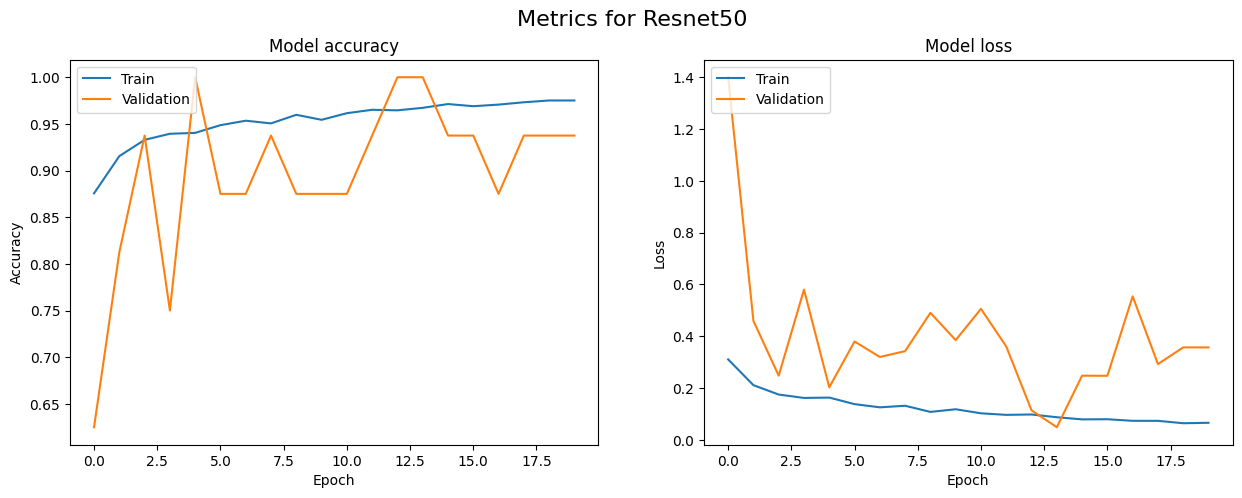

Confusion matrix saved to resnet50_confusion_matrix.png


2025/09/20 12:57:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 12:57:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmplnmbtgmm/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
 

Logged model and registered as 'pneumonia-detection-resnet50'.


2025/09/20 12:57:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/20 12:57:22 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/09/20 12:57:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model saved to resnet50_best.pth

  COMPLETED MLFLOW RUN FOR: RESNET50


  STARTING MLFLOW RUN FOR: RESNEXT50



Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 224MB/s]


Epoch 1/20
----------


Train Epoch 1/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.16]


train Loss: 0.2867 Acc: 0.8775


Val Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.627]


val Loss: 0.6274 Acc: 0.6875

Epoch 2/20
----------


Train Epoch 2/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.038]


train Loss: 0.2082 Acc: 0.9216


Val Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.992]


val Loss: 0.9915 Acc: 0.6250

Epoch 3/20
----------


Train Epoch 3/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.0642]


train Loss: 0.1677 Acc: 0.9346


Val Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, loss=1.09]


val Loss: 1.0904 Acc: 0.6250

Epoch 4/20
----------


Train Epoch 4/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.472]


train Loss: 0.1634 Acc: 0.9375


Val Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.714]


val Loss: 0.7144 Acc: 0.6250

Epoch 5/20
----------


Train Epoch 5/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.131]


train Loss: 0.1513 Acc: 0.9452


Val Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.242]


val Loss: 0.2418 Acc: 0.9375

Epoch 6/20
----------


Train Epoch 6/20: 100%|██████████| 326/326 [00:53<00:00,  6.11it/s, loss=0.184]


train Loss: 0.1390 Acc: 0.9490


Val Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss=0.208]


val Loss: 0.2076 Acc: 0.9375

Epoch 7/20
----------


Train Epoch 7/20: 100%|██████████| 326/326 [00:53<00:00,  6.11it/s, loss=0.00927]


train Loss: 0.1264 Acc: 0.9534


Val Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss=0.974]


val Loss: 0.9745 Acc: 0.6250

Epoch 8/20
----------


Train Epoch 8/20: 100%|██████████| 326/326 [00:53<00:00,  6.11it/s, loss=0.0171]


train Loss: 0.1278 Acc: 0.9519


Val Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, loss=0.211]


val Loss: 0.2111 Acc: 1.0000

Epoch 9/20
----------


Train Epoch 9/20: 100%|██████████| 326/326 [00:53<00:00,  6.08it/s, loss=0.114]


train Loss: 0.1111 Acc: 0.9551


Val Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.632]


val Loss: 0.6321 Acc: 0.8125

Epoch 10/20
----------


Train Epoch 10/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.0487]


train Loss: 0.0993 Acc: 0.9609


Val Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, loss=0.392]


val Loss: 0.3923 Acc: 0.7500

Epoch 11/20
----------


Train Epoch 11/20: 100%|██████████| 326/326 [00:53<00:00,  6.11it/s, loss=0.355]


train Loss: 0.1008 Acc: 0.9636


Val Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, loss=0.252]


val Loss: 0.2522 Acc: 1.0000

Epoch 12/20
----------


Train Epoch 12/20: 100%|██████████| 326/326 [00:53<00:00,  6.08it/s, loss=0.0428]


train Loss: 0.0901 Acc: 0.9640


Val Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s, loss=0.171]


val Loss: 0.1708 Acc: 0.9375

Epoch 13/20
----------


Train Epoch 13/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.131]


train Loss: 0.0898 Acc: 0.9634


Val Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s, loss=0.0789]


val Loss: 0.0789 Acc: 1.0000

Epoch 14/20
----------


Train Epoch 14/20: 100%|██████████| 326/326 [00:53<00:00,  6.12it/s, loss=0.0819]


train Loss: 0.0760 Acc: 0.9703


Val Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.127]


val Loss: 0.1274 Acc: 1.0000

Epoch 15/20
----------


Train Epoch 15/20: 100%|██████████| 326/326 [00:53<00:00,  6.10it/s, loss=0.0032]


train Loss: 0.0755 Acc: 0.9711


Val Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s, loss=0.161]


val Loss: 0.1611 Acc: 0.9375

Epoch 16/20
----------


Train Epoch 16/20: 100%|██████████| 326/326 [00:53<00:00,  6.12it/s, loss=0.0333]


train Loss: 0.0668 Acc: 0.9751


Val Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, loss=0.236]


val Loss: 0.2363 Acc: 0.9375

Epoch 17/20
----------


Train Epoch 17/20: 100%|██████████| 326/326 [00:53<00:00,  6.12it/s, loss=0.00285]


train Loss: 0.0602 Acc: 0.9757


Val Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, loss=0.198]


val Loss: 0.1981 Acc: 0.9375

Epoch 18/20
----------


Train Epoch 18/20: 100%|██████████| 326/326 [00:53<00:00,  6.12it/s, loss=0.0278]


train Loss: 0.0699 Acc: 0.9737


Val Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.183]


val Loss: 0.1829 Acc: 0.9375

Epoch 19/20
----------


Train Epoch 19/20: 100%|██████████| 326/326 [00:53<00:00,  6.09it/s, loss=0.00697]


train Loss: 0.0583 Acc: 0.9787


Val Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss=0.229]


val Loss: 0.2291 Acc: 0.9375

Epoch 20/20
----------


Train Epoch 20/20: 100%|██████████| 326/326 [00:53<00:00,  6.08it/s, loss=0.0018]


train Loss: 0.0628 Acc: 0.9757


Val Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, loss=0.208]


val Loss: 0.2078 Acc: 0.9375

Training complete in 17m 60s
Best val Acc: 1.000000


Testing: 100%|██████████| 39/39 [00:05<00:00,  7.52it/s, loss=0.169]



Test Results:
Test Loss: 0.2017
Test Accuracy: 0.9535 (595/624)
Metrics plot saved to resnext50_training_metrics.png


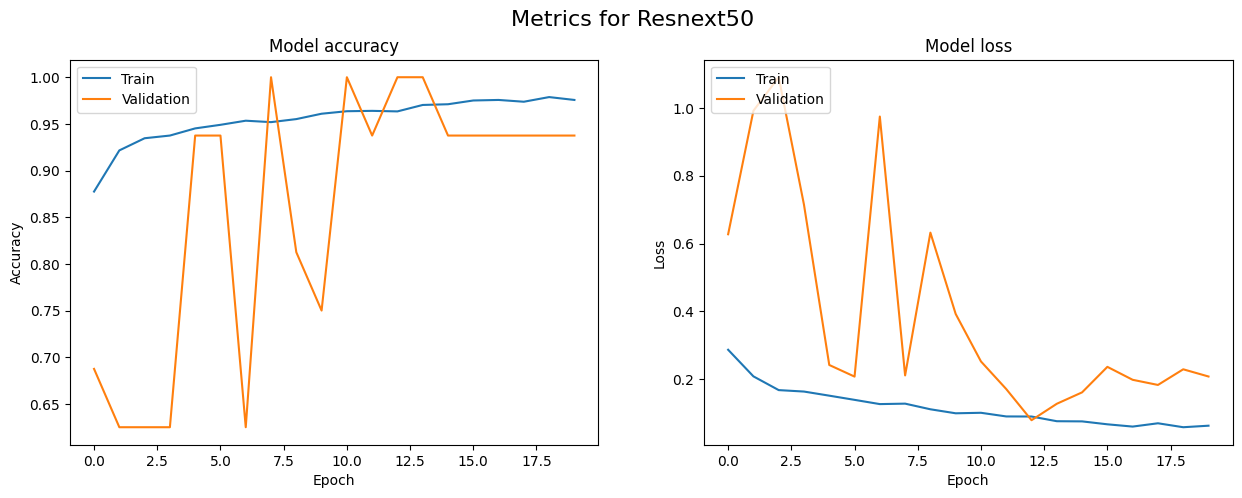

Confusion matrix saved to resnext50_confusion_matrix.png


2025/09/20 13:15:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 13:15:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpq_f8al01/model/data, flavor: pytorch). Fall back to return ['torch==2.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'pneumonia-detection-resnext50'.
Created version '1' of model 'pneumonia-detection-resnext50'.
2025/09/20 13:15:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/20 13:15:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated sy

Logged model and registered as 'pneumonia-detection-resnext50'.
Model saved to resnext50_best.pth

  COMPLETED MLFLOW RUN FOR: RESNEXT50


  STARTING MLFLOW RUN FOR: EFFICIENTNET_V2_S



Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 167MB/s]


Epoch 1/20
----------


Train Epoch 1/20: 100%|██████████| 326/326 [00:56<00:00,  5.80it/s, loss=0.427]


train Loss: 0.3065 Acc: 0.8618


Val Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=1.46]


val Loss: 1.4645 Acc: 0.6250

Epoch 2/20
----------


Train Epoch 2/20: 100%|██████████| 326/326 [00:55<00:00,  5.83it/s, loss=0.0892]


train Loss: 0.2044 Acc: 0.9164


Val Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss=1.29]


val Loss: 1.2928 Acc: 0.6875

Epoch 3/20
----------


Train Epoch 3/20: 100%|██████████| 326/326 [00:55<00:00,  5.84it/s, loss=0.141]


train Loss: 0.1833 Acc: 0.9273


Val Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, loss=0.341]


val Loss: 0.3406 Acc: 0.9375

Epoch 4/20
----------


Train Epoch 4/20: 100%|██████████| 326/326 [00:55<00:00,  5.86it/s, loss=0.0942]


train Loss: 0.1653 Acc: 0.9394


Val Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s, loss=0.224]


val Loss: 0.2244 Acc: 0.9375

Epoch 5/20
----------


Train Epoch 5/20: 100%|██████████| 326/326 [00:55<00:00,  5.83it/s, loss=0.13]


train Loss: 0.1611 Acc: 0.9392


Val Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.652]


val Loss: 0.6519 Acc: 0.7500

Epoch 6/20
----------


Train Epoch 6/20: 100%|██████████| 326/326 [00:56<00:00,  5.76it/s, loss=0.184]


train Loss: 0.1447 Acc: 0.9446


Val Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.65]


val Loss: 0.6499 Acc: 0.8125

Epoch 7/20
----------


Train Epoch 7/20: 100%|██████████| 326/326 [00:56<00:00,  5.80it/s, loss=0.0906]


train Loss: 0.1260 Acc: 0.9507


Val Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.332]


val Loss: 0.3315 Acc: 0.8125

Epoch 8/20
----------


Train Epoch 8/20: 100%|██████████| 326/326 [00:55<00:00,  5.84it/s, loss=0.135]


train Loss: 0.1239 Acc: 0.9523


Val Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.967]


val Loss: 0.9672 Acc: 0.6875

Epoch 9/20
----------


Train Epoch 9/20: 100%|██████████| 326/326 [00:56<00:00,  5.79it/s, loss=0.0107]


train Loss: 0.1172 Acc: 0.9551


Val Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.0752]


val Loss: 0.0752 Acc: 1.0000

Epoch 10/20
----------


Train Epoch 10/20: 100%|██████████| 326/326 [00:56<00:00,  5.82it/s, loss=0.0984]


train Loss: 0.0998 Acc: 0.9618


Val Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.267]


val Loss: 0.2673 Acc: 0.8750

Epoch 11/20
----------


Train Epoch 11/20: 100%|██████████| 326/326 [00:56<00:00,  5.79it/s, loss=0.0129]


train Loss: 0.0969 Acc: 0.9641


Val Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.4]


val Loss: 0.4004 Acc: 0.8125

Epoch 12/20
----------


Train Epoch 12/20: 100%|██████████| 326/326 [00:55<00:00,  5.83it/s, loss=0.0574]


train Loss: 0.0925 Acc: 0.9661


Val Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.688]


val Loss: 0.6878 Acc: 0.7500

Epoch 13/20
----------


Train Epoch 13/20: 100%|██████████| 326/326 [00:56<00:00,  5.74it/s, loss=0.0235]


train Loss: 0.0851 Acc: 0.9712


Val Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.665]


val Loss: 0.6650 Acc: 0.7500

Epoch 14/20
----------


Train Epoch 14/20: 100%|██████████| 326/326 [00:56<00:00,  5.78it/s, loss=0.0218]


train Loss: 0.0763 Acc: 0.9720


Val Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss=0.894]


val Loss: 0.8942 Acc: 0.7500

Epoch 15/20
----------


Train Epoch 15/20: 100%|██████████| 326/326 [00:56<00:00,  5.81it/s, loss=0.0209]


train Loss: 0.0781 Acc: 0.9734


Val Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.305]


val Loss: 0.3046 Acc: 0.8750

Epoch 16/20
----------


Train Epoch 16/20: 100%|██████████| 326/326 [00:56<00:00,  5.81it/s, loss=0.00533]


train Loss: 0.0693 Acc: 0.9735


Val Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss=0.624]


val Loss: 0.6245 Acc: 0.8125

Epoch 17/20
----------


Train Epoch 17/20: 100%|██████████| 326/326 [00:56<00:00,  5.81it/s, loss=0.0475]


train Loss: 0.0669 Acc: 0.9753


Val Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, loss=0.55]


val Loss: 0.5496 Acc: 0.8125

Epoch 18/20
----------


Train Epoch 18/20: 100%|██████████| 326/326 [00:55<00:00,  5.82it/s, loss=0.0245]


train Loss: 0.0532 Acc: 0.9787


Val Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss=0.384]


val Loss: 0.3844 Acc: 0.8750

Epoch 19/20
----------


Train Epoch 19/20: 100%|██████████| 326/326 [00:55<00:00,  5.83it/s, loss=0.0395]


train Loss: 0.0608 Acc: 0.9787


Val Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s, loss=0.307]


val Loss: 0.3074 Acc: 0.8750

Epoch 20/20
----------


Train Epoch 20/20: 100%|██████████| 326/326 [00:57<00:00,  5.72it/s, loss=0.0387]


train Loss: 0.0605 Acc: 0.9766


Val Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.345]


val Loss: 0.3450 Acc: 0.8750

Training complete in 18m 56s
Best val Acc: 1.000000


Testing: 100%|██████████| 39/39 [00:05<00:00,  7.29it/s, loss=0.513]



Test Results:
Test Loss: 0.1744
Test Accuracy: 0.9615 (600/624)
Metrics plot saved to efficientnet_v2_s_training_metrics.png


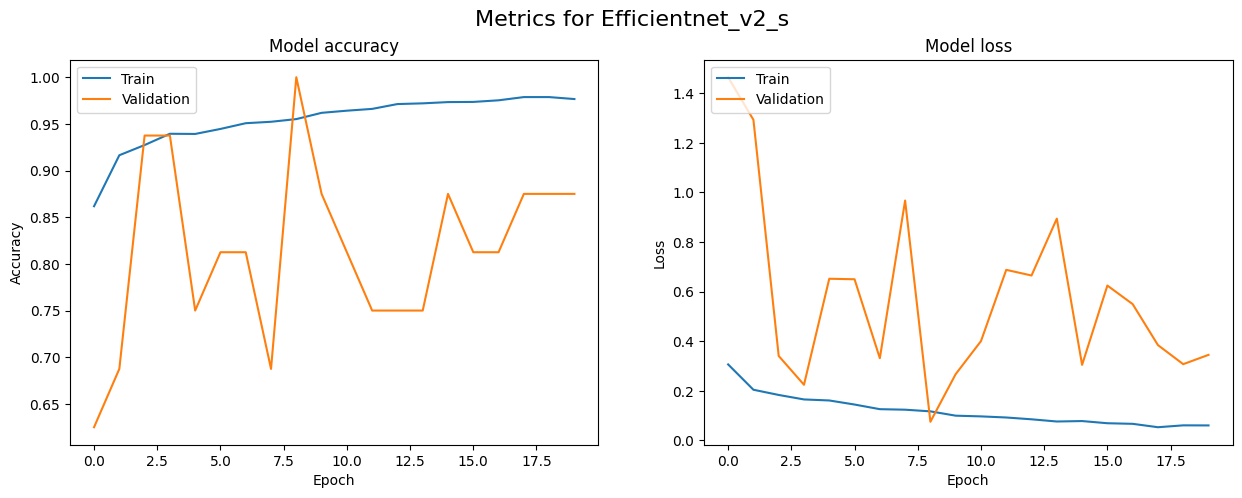

Confusion matrix saved to efficientnet_v2_s_confusion_matrix.png


2025/09/20 13:34:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 13:35:02 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'dataproc-spark-connect'}
2025/09/20 13:35:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local v

Logged model and registered as 'pneumonia-detection-efficientnet_v2_s'.


2025/09/20 13:35:03 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/20 13:35:03 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/09/20 13:35:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model saved to efficientnet_v2_s_best.pth

  COMPLETED MLFLOW RUN FOR: EFFICIENTNET_V2_S


  STARTING MLFLOW RUN FOR: CONVNEXT_TINY



Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 203MB/s] 


Epoch 1/20
----------


Train Epoch 1/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.067]


train Loss: 0.2708 Acc: 0.8901


Val Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.871]


val Loss: 0.8706 Acc: 0.6875

Epoch 2/20
----------


Train Epoch 2/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.0408]


train Loss: 0.1830 Acc: 0.9252


Val Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.405]


val Loss: 0.4050 Acc: 0.8125

Epoch 3/20
----------


Train Epoch 3/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.294]


train Loss: 0.1533 Acc: 0.9383


Val Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.153]


val Loss: 0.1534 Acc: 0.8750

Epoch 4/20
----------


Train Epoch 4/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.136]


train Loss: 0.1477 Acc: 0.9433


Val Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.0509]


val Loss: 0.0509 Acc: 1.0000

Epoch 5/20
----------


Train Epoch 5/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.258]


train Loss: 0.1300 Acc: 0.9525


Val Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.737]


val Loss: 0.7373 Acc: 0.6875

Epoch 6/20
----------


Train Epoch 6/20: 100%|██████████| 326/326 [04:21<00:00,  1.25it/s, loss=0.157]


train Loss: 0.1238 Acc: 0.9532


Val Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.933]


val Loss: 0.9327 Acc: 0.7500

Epoch 7/20
----------


Train Epoch 7/20: 100%|██████████| 326/326 [04:21<00:00,  1.25it/s, loss=0.0126]


train Loss: 0.1053 Acc: 0.9592


Val Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.0331]


val Loss: 0.0331 Acc: 1.0000

Epoch 8/20
----------


Train Epoch 8/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.00919]


train Loss: 0.1163 Acc: 0.9536


Val Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.0266]


val Loss: 0.0266 Acc: 1.0000

Epoch 9/20
----------


Train Epoch 9/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.0195]


train Loss: 0.0938 Acc: 0.9661


Val Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.0597]


val Loss: 0.0597 Acc: 1.0000

Epoch 10/20
----------


Train Epoch 10/20: 100%|██████████| 326/326 [04:21<00:00,  1.25it/s, loss=0.147]


train Loss: 0.0913 Acc: 0.9643


Val Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.0395]


val Loss: 0.0395 Acc: 1.0000

Epoch 11/20
----------


Train Epoch 11/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.29]


train Loss: 0.0899 Acc: 0.9672


Val Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.0289]


val Loss: 0.0289 Acc: 1.0000

Epoch 12/20
----------


Train Epoch 12/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.00868]


train Loss: 0.0899 Acc: 0.9663


Val Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.0179]


val Loss: 0.0179 Acc: 1.0000

Epoch 13/20
----------


Train Epoch 13/20: 100%|██████████| 326/326 [04:21<00:00,  1.25it/s, loss=0.036]


train Loss: 0.0642 Acc: 0.9751


Val Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.0725]


val Loss: 0.0725 Acc: 1.0000

Epoch 14/20
----------


Train Epoch 14/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.136]


train Loss: 0.0602 Acc: 0.9768


Val Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.712]


val Loss: 0.7120 Acc: 0.8750

Epoch 15/20
----------


Train Epoch 15/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.0588]


train Loss: 0.0627 Acc: 0.9770


Val Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.237]


val Loss: 0.2368 Acc: 0.9375

Epoch 16/20
----------


Train Epoch 16/20: 100%|██████████| 326/326 [04:21<00:00,  1.25it/s, loss=0.00562]


train Loss: 0.0561 Acc: 0.9797


Val Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.369]


val Loss: 0.3686 Acc: 0.8750

Epoch 17/20
----------


Train Epoch 17/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.0268]


train Loss: 0.0543 Acc: 0.9820


Val Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss=0.448]


val Loss: 0.4481 Acc: 0.8750

Epoch 18/20
----------


Train Epoch 18/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.000965]


train Loss: 0.0513 Acc: 0.9801


Val Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.171]


val Loss: 0.1710 Acc: 0.9375

Epoch 19/20
----------


Train Epoch 19/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.00531]


train Loss: 0.0535 Acc: 0.9780


Val Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.307]


val Loss: 0.3071 Acc: 0.8750

Epoch 20/20
----------


Train Epoch 20/20: 100%|██████████| 326/326 [04:20<00:00,  1.25it/s, loss=0.204]


train Loss: 0.0475 Acc: 0.9826


Val Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.378]


val Loss: 0.3779 Acc: 0.8750

Training complete in 87m 10s
Best val Acc: 1.000000


Testing: 100%|██████████| 39/39 [00:05<00:00,  6.97it/s, loss=0.0103]



Test Results:
Test Loss: 0.1877
Test Accuracy: 0.9567 (597/624)
Metrics plot saved to convnext_tiny_training_metrics.png


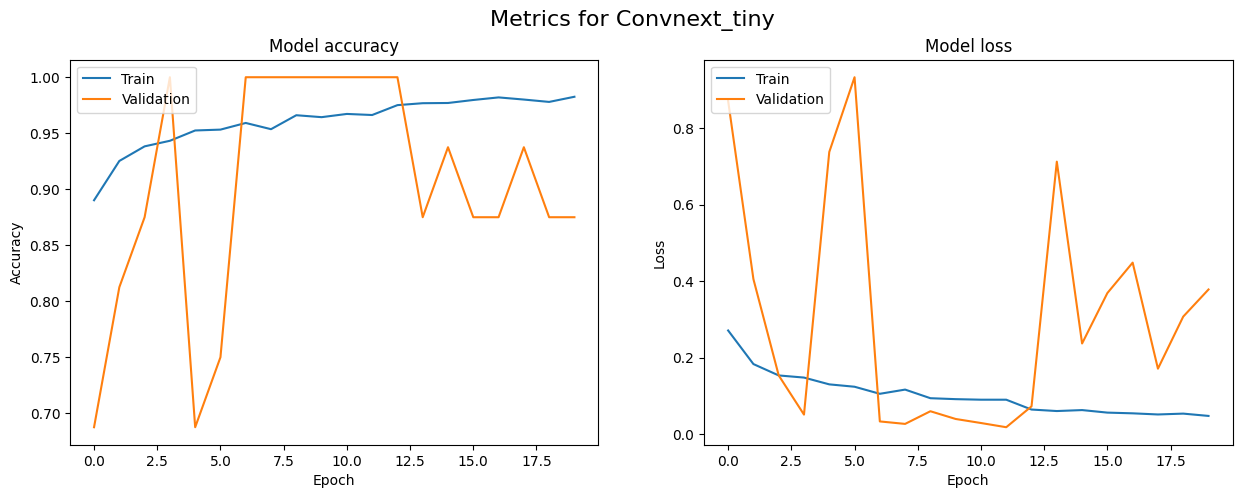

Confusion matrix saved to convnext_tiny_confusion_matrix.png


2025/09/20 15:02:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 15:02:34 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'dataproc-spark-connect'}
2025/09/20 15:02:34 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local v

Logged model and registered as 'pneumonia-detection-convnext_tiny'.
Model saved to convnext_tiny_best.pth

  COMPLETED MLFLOW RUN FOR: CONVNEXT_TINY



2025/09/20 15:02:35 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/09/20 15:02:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.



  STARTING MLFLOW RUN FOR: VIT_B_16



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 195MB/s]


Epoch 1/20
----------


Train Epoch 1/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.439]


train Loss: 0.4470 Acc: 0.7929


Val Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=1.24]


val Loss: 1.2435 Acc: 0.6250

Epoch 2/20
----------


Train Epoch 2/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.0874]


train Loss: 0.3185 Acc: 0.8618


Val Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, loss=1.97]


val Loss: 1.9691 Acc: 0.6250

Epoch 3/20
----------


Train Epoch 3/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.17]


train Loss: 0.2871 Acc: 0.8813


Val Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, loss=1.48]


val Loss: 1.4819 Acc: 0.6250

Epoch 4/20
----------


Train Epoch 4/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.236]


train Loss: 0.2785 Acc: 0.8840


Val Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=1.05]


val Loss: 1.0475 Acc: 0.6250

Epoch 5/20
----------


Train Epoch 5/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.32]


train Loss: 0.2374 Acc: 0.9043


Val Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss=0.842]


val Loss: 0.8418 Acc: 0.6250

Epoch 6/20
----------


Train Epoch 6/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.157]


train Loss: 0.2234 Acc: 0.9099


Val Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, loss=0.564]


val Loss: 0.5645 Acc: 0.8125

Epoch 7/20
----------


Train Epoch 7/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.281]


train Loss: 0.2128 Acc: 0.9130


Val Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, loss=0.683]


val Loss: 0.6833 Acc: 0.6875

Epoch 8/20
----------


Train Epoch 8/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.138]


train Loss: 0.2046 Acc: 0.9174


Val Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=0.369]


val Loss: 0.3690 Acc: 0.8750

Epoch 9/20
----------


Train Epoch 9/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.0779]


train Loss: 0.1937 Acc: 0.9250


Val Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=0.26]


val Loss: 0.2598 Acc: 1.0000

Epoch 10/20
----------


Train Epoch 10/20: 100%|██████████| 326/326 [01:41<00:00,  3.21it/s, loss=0.233]


train Loss: 0.1704 Acc: 0.9279


Val Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, loss=0.743]


val Loss: 0.7425 Acc: 0.6875

Epoch 11/20
----------


Train Epoch 11/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.0884]


train Loss: 0.1624 Acc: 0.9375


Val Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, loss=0.4]


val Loss: 0.3999 Acc: 0.9375

Epoch 12/20
----------


Train Epoch 12/20: 100%|██████████| 326/326 [01:42<00:00,  3.20it/s, loss=0.164]


train Loss: 0.1602 Acc: 0.9377


Val Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, loss=0.576]


val Loss: 0.5765 Acc: 0.6875

Epoch 13/20
----------


Train Epoch 13/20: 100%|██████████| 326/326 [01:42<00:00,  3.19it/s, loss=0.0795]


train Loss: 0.1529 Acc: 0.9383


Val Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, loss=0.392]


val Loss: 0.3918 Acc: 0.8125

Epoch 14/20
----------


Train Epoch 14/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.181]


train Loss: 0.1394 Acc: 0.9475


Val Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=0.905]


val Loss: 0.9052 Acc: 0.6875

Epoch 15/20
----------


Train Epoch 15/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.115]


train Loss: 0.1304 Acc: 0.9473


Val Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.392]


val Loss: 0.3916 Acc: 0.8750

Epoch 16/20
----------


Train Epoch 16/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.24]


train Loss: 0.1242 Acc: 0.9519


Val Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, loss=0.284]


val Loss: 0.2843 Acc: 0.9375

Epoch 17/20
----------


Train Epoch 17/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.0147]


train Loss: 0.1086 Acc: 0.9557


Val Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss=0.225]


val Loss: 0.2250 Acc: 0.9375

Epoch 18/20
----------


Train Epoch 18/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.00705]


train Loss: 0.0940 Acc: 0.9634


Val Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=0.109]


val Loss: 0.1094 Acc: 1.0000

Epoch 19/20
----------


Train Epoch 19/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.0906]


train Loss: 0.1066 Acc: 0.9605


Val Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=0.168]


val Loss: 0.1677 Acc: 1.0000

Epoch 20/20
----------


Train Epoch 20/20: 100%|██████████| 326/326 [01:41<00:00,  3.20it/s, loss=0.0411]


train Loss: 0.1073 Acc: 0.9594


Val Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=0.178]


val Loss: 0.1783 Acc: 1.0000

Training complete in 34m 10s
Best val Acc: 1.000000


Testing: 100%|██████████| 39/39 [00:07<00:00,  5.41it/s, loss=0.35]



Test Results:
Test Loss: 0.1635
Test Accuracy: 0.9359 (584/624)
Metrics plot saved to vit_b_16_training_metrics.png


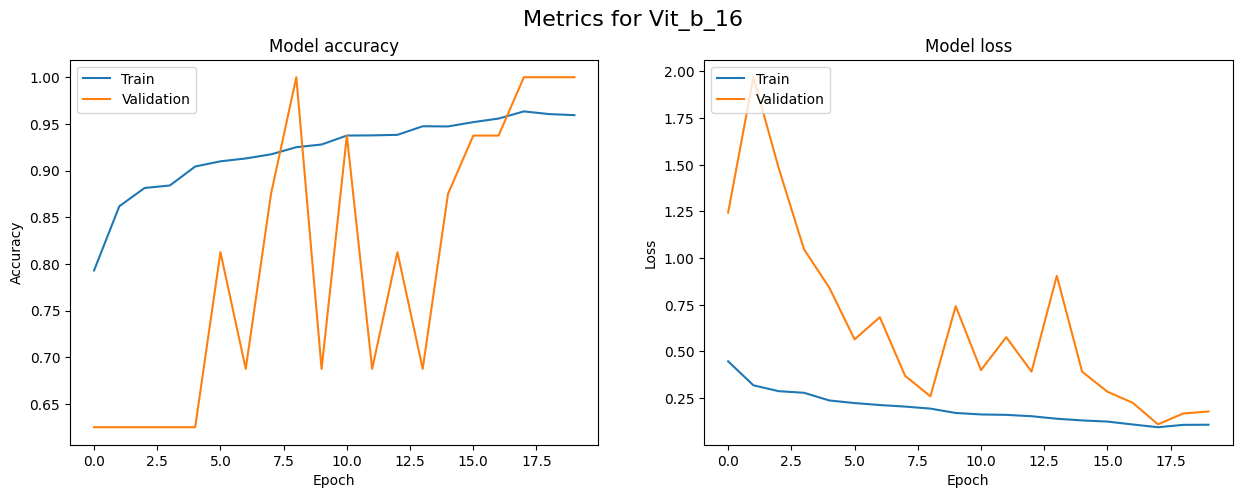

Confusion matrix saved to vit_b_16_confusion_matrix.png


2025/09/20 15:37:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 15:37:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'dataproc-spark-connect'}
2025/09/20 15:37:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local v

Logged model and registered as 'pneumonia-detection-vit_b_16'.


2025/09/20 15:37:14 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/20 15:37:14 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2025/09/20 15:37:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model saved to vit_b_16_best.pth

  COMPLETED MLFLOW RUN FOR: VIT_B_16


  STARTING MLFLOW RUN FOR: SWIN_T



Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 220MB/s]


Epoch 1/20
----------


Train Epoch 1/20: 100%|██████████| 326/326 [00:51<00:00,  6.36it/s, loss=0.152]


train Loss: 0.3853 Acc: 0.8227


Val Epoch 1/20: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.334]


val Loss: 0.3340 Acc: 0.8125

Epoch 2/20
----------


Train Epoch 2/20: 100%|██████████| 326/326 [00:50<00:00,  6.48it/s, loss=0.155]


train Loss: 0.2510 Acc: 0.8995


Val Epoch 2/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.24]


val Loss: 0.2401 Acc: 0.8125

Epoch 3/20
----------


Train Epoch 3/20: 100%|██████████| 326/326 [00:50<00:00,  6.43it/s, loss=0.371]


train Loss: 0.2222 Acc: 0.9101


Val Epoch 3/20: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=1.05]


val Loss: 1.0474 Acc: 0.6250

Epoch 4/20
----------


Train Epoch 4/20: 100%|██████████| 326/326 [00:50<00:00,  6.48it/s, loss=0.2]


train Loss: 0.2090 Acc: 0.9168


Val Epoch 4/20: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.302]


val Loss: 0.3021 Acc: 0.8750

Epoch 5/20
----------


Train Epoch 5/20: 100%|██████████| 326/326 [00:50<00:00,  6.44it/s, loss=0.106]


train Loss: 0.1678 Acc: 0.9337


Val Epoch 5/20: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.885]


val Loss: 0.8846 Acc: 0.6250

Epoch 6/20
----------


Train Epoch 6/20: 100%|██████████| 326/326 [00:50<00:00,  6.47it/s, loss=0.407]


train Loss: 0.1650 Acc: 0.9379


Val Epoch 6/20: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.262]


val Loss: 0.2618 Acc: 0.8750

Epoch 7/20
----------


Train Epoch 7/20: 100%|██████████| 326/326 [00:50<00:00,  6.48it/s, loss=0.246]


train Loss: 0.1514 Acc: 0.9415


Val Epoch 7/20: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=0.0492]


val Loss: 0.0492 Acc: 0.9375

Epoch 8/20
----------


Train Epoch 8/20: 100%|██████████| 326/326 [00:50<00:00,  6.47it/s, loss=0.122]


train Loss: 0.1522 Acc: 0.9410


Val Epoch 8/20: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.179]


val Loss: 0.1785 Acc: 1.0000

Epoch 9/20
----------


Train Epoch 9/20: 100%|██████████| 326/326 [00:50<00:00,  6.49it/s, loss=0.0703]


train Loss: 0.1407 Acc: 0.9452


Val Epoch 9/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.152]


val Loss: 0.1518 Acc: 1.0000

Epoch 10/20
----------


Train Epoch 10/20: 100%|██████████| 326/326 [00:50<00:00,  6.41it/s, loss=0.0785]


train Loss: 0.1239 Acc: 0.9511


Val Epoch 10/20: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.758]


val Loss: 0.7584 Acc: 0.6875

Epoch 11/20
----------


Train Epoch 11/20: 100%|██████████| 326/326 [00:50<00:00,  6.48it/s, loss=0.478]


train Loss: 0.1311 Acc: 0.9503


Val Epoch 11/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.263]


val Loss: 0.2628 Acc: 0.9375

Epoch 12/20
----------


Train Epoch 12/20: 100%|██████████| 326/326 [00:50<00:00,  6.44it/s, loss=0.0391]


train Loss: 0.1113 Acc: 0.9574


Val Epoch 12/20: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.142]


val Loss: 0.1417 Acc: 1.0000

Epoch 13/20
----------


Train Epoch 13/20: 100%|██████████| 326/326 [00:50<00:00,  6.48it/s, loss=0.0266]


train Loss: 0.1169 Acc: 0.9553


Val Epoch 13/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.133]


val Loss: 0.1327 Acc: 1.0000

Epoch 14/20
----------


Train Epoch 14/20: 100%|██████████| 326/326 [00:50<00:00,  6.47it/s, loss=0.0558]


train Loss: 0.1099 Acc: 0.9595


Val Epoch 14/20: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, loss=0.125]


val Loss: 0.1252 Acc: 1.0000

Epoch 15/20
----------


Train Epoch 15/20: 100%|██████████| 326/326 [00:50<00:00,  6.40it/s, loss=0.0747]


train Loss: 0.0960 Acc: 0.9655


Val Epoch 15/20: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.233]


val Loss: 0.2329 Acc: 0.9375

Epoch 16/20
----------


Train Epoch 16/20: 100%|██████████| 326/326 [00:50<00:00,  6.47it/s, loss=0.0328]


train Loss: 0.0911 Acc: 0.9670


Val Epoch 16/20: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.0914]


val Loss: 0.0914 Acc: 1.0000

Epoch 17/20
----------


Train Epoch 17/20: 100%|██████████| 326/326 [00:50<00:00,  6.42it/s, loss=0.156]


train Loss: 0.0784 Acc: 0.9693


Val Epoch 17/20: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.0802]


val Loss: 0.0802 Acc: 1.0000

Epoch 18/20
----------


Train Epoch 18/20: 100%|██████████| 326/326 [00:50<00:00,  6.48it/s, loss=0.0795]


train Loss: 0.0827 Acc: 0.9693


Val Epoch 18/20: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.0744]


val Loss: 0.0744 Acc: 1.0000

Epoch 19/20
----------


Train Epoch 19/20: 100%|██████████| 326/326 [00:50<00:00,  6.44it/s, loss=0.0893]


train Loss: 0.0845 Acc: 0.9682


Val Epoch 19/20: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.14]


val Loss: 0.1396 Acc: 1.0000

Epoch 20/20
----------


Train Epoch 20/20: 100%|██████████| 326/326 [00:50<00:00,  6.42it/s, loss=0.153]


train Loss: 0.0806 Acc: 0.9664


Val Epoch 20/20: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.128]


val Loss: 0.1281 Acc: 1.0000

Training complete in 17m 4s
Best val Acc: 1.000000


Testing: 100%|██████████| 39/39 [00:05<00:00,  7.22it/s, loss=0.584]



Test Results:
Test Loss: 0.1964
Test Accuracy: 0.9487 (592/624)
Metrics plot saved to swin_t_training_metrics.png


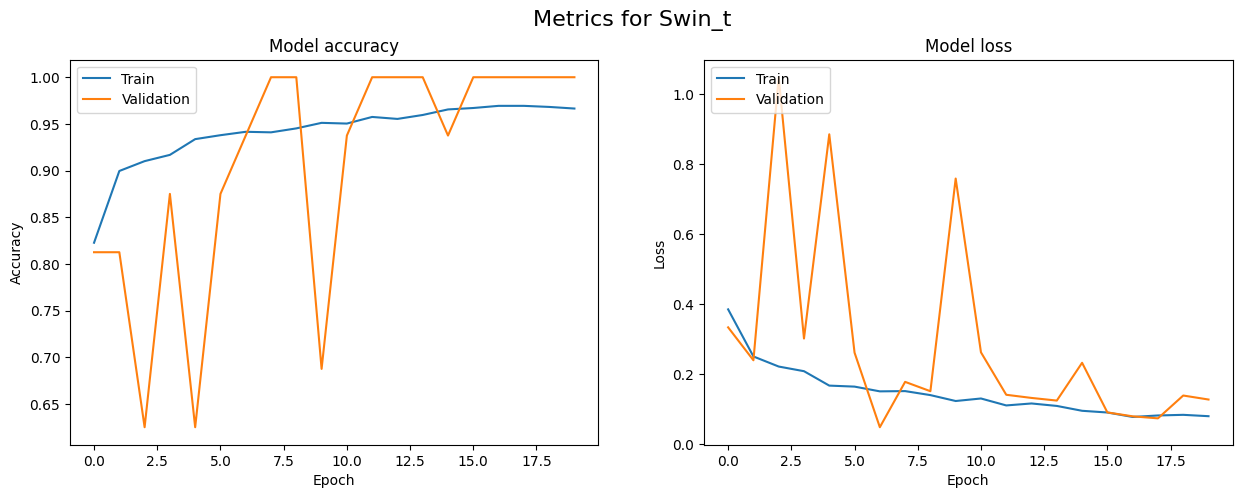

Confusion matrix saved to swin_t_confusion_matrix.png


2025/09/20 15:54:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 15:54:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'dataproc-spark-connect'}
2025/09/20 15:54:39 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local v

Logged model and registered as 'pneumonia-detection-swin_t'.
Model saved to swin_t_best.pth

  COMPLETED MLFLOW RUN FOR: SWIN_T



2025/09/20 15:54:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [15]:
# Set up MLflow
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.enable_system_metrics_logging()
    
# Calculate class weights
if LOSS_FUNCTION_TYPE == 'weighted':
    num_normal = len(os.listdir(os.path.join(DATA_DIR, 'train', 'NORMAL')))
    num_pneumonia = len(os.listdir(os.path.join(DATA_DIR, 'train', 'PNEUMONIA')))
    total = num_normal + num_pneumonia
    weight_for_normal = total / (2.0 * num_normal)
    weight_for_pneumonia = total / (2.0 * num_pneumonia)
    class_weights = torch.tensor([weight_for_normal, weight_for_pneumonia]).to(device)
    print(f"Using weighted loss. Class weights: {class_weights}")
else:
    class_weights = None
    print("Using standard (unweighted) loss.")

# These lists will be populated and used by later cells
files_to_archive = []
experiment_results = {}





# Get a sample input and convert it to a NumPy array for the MLflow signature
sample_input_tensor, _ = next(iter(dataloaders['val']))
input_example = sample_input_tensor.cpu().numpy()

# --- Main loop to train each model ---
for model_name in MODELS_TO_TRAIN:
    with mlflow.start_run(run_name=f"{model_name}"):
        print(f"\n{'='*25}\n  STARTING MLFLOW RUN FOR: {model_name.upper()}\n{'='*25}\n")

        # MlFlow MetaData Tracking
        mlflow.set_tag("run_group", RUN_TAG)
        mlflow.log_input(META_DATA_W_SCHEMA, context="external_data")
        mlflow.set_tag("environment", "Kaggle")
        mlflow.set_tag("pytorch_version", torch.__version__)
        mlflow.set_tag("run_author", "chillguycode")

        
        model = get_model(model_name, num_classes)
        
        # Log Hyperparameters
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        params = {
            "model_name": model_name,
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
            "num_epochs": NUM_EPOCHS,
            "weight_decay": WEIGHT_DECAY,
            "optimizer": OPTIMIZER_TYPE,
            "lr_scheduler": SCHEDULER_TYPE,
            "loss_function": LOSS_FUNCTION_TYPE,
            "image_size": 224, # Assuming 224 from your transforms
            "trainable_params": num_params
        }
        mlflow.log_params(params)

        # Create Optimizer, Loss, and Scheduler
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        if OPTIMIZER_TYPE == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        else: # Add other optimizers if needed
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        if SCHEDULER_TYPE == 'cosine':
            scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        else:
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1.0)
        
        # Train and Evaluate
        trained_model, history, best_val_labels, best_val_preds = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)
        test_loss, test_acc = test_model(trained_model, criterion)
        
        # Store results for the summary table
        experiment_results[model_name] = {
            'test_acc': test_acc,
            'test_loss': test_loss,
            'best_val_acc': max(history['val_acc'])
        }

        # Log to MLflow
        mlflow.log_metric("final_test_loss", test_loss); mlflow.log_metric("final_test_acc", test_acc)
        
        plot_path = plot_metrics(history, model_name)
        mlflow.log_artifact(plot_path, "plots")
        files_to_archive.append(plot_path)

        if best_val_labels and best_val_preds:
            cm_path = log_confusion_matrix(best_val_labels, best_val_preds, model_name)
            mlflow.log_artifact(cm_path, "plots")
            files_to_archive.append(cm_path)
        
        # --- FIX: Move model to CPU for logging to avoid device mismatch errors ---
        trained_model.cpu()
        
        # === FIX FOR MLFLOW v2.x ===
        mlflow.pytorch.log_model(
            pytorch_model=trained_model,
            artifact_path=model_name,
            input_example=input_example,
            # This is the new line that registers the model
            registered_model_name=f"pneumonia-detection-{model_name}" 
        )
        print(f"Logged model and registered as 'pneumonia-detection-{model_name}'.")
        
        # --- FIX: Move model back to the GPU for saving and any further use ---
        trained_model.to(device)
        
        model_path = save_model(trained_model, model_name)
        files_to_archive.append(model_path)
        
        print(f"\n{'='*25}\n  COMPLETED MLFLOW RUN FOR: {model_name.upper()}\n{'='*25}\n")

# Unset the environment variable to avoid affecting other sessions
if "MLFLOW_LOG_SYSTEM_METRICS" in os.environ:
    del os.environ["MLFLOW_LOG_SYSTEM_METRICS"]

# Visualisation


--- Experiment Results Summary ---
----------------------------------------------------------------------------------------
| Model Name           | Test Accuracy (%)    | Test Loss       | Best Val Acc (%)     |
----------------------------------------------------------------------------------------
| resnet50             | 94.71                | 0.2071          | 100.00               |
| resnext50            | 95.35                | 0.2017          | 100.00               |
| efficientnet_v2_s    | 96.15                | 0.1744          | 100.00               |
| convnext_tiny        | 95.67                | 0.1877          | 100.00               |
| vit_b_16             | 93.59                | 0.1635          | 100.00               |
| swin_t               | 94.87                | 0.1964          | 100.00               |
----------------------------------------------------------------------------------------

Best performing model based on Test Accuracy: efficientnet_v2_s (Accuracy

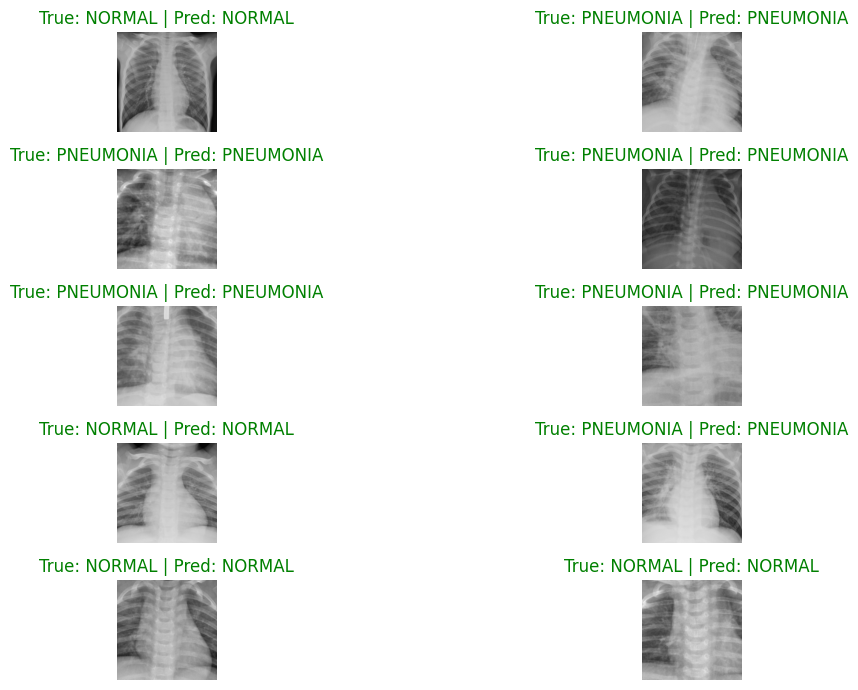

In [16]:
# Check if the results dictionary exists and is not empty
if 'experiment_results' in locals() and experiment_results:
    # --- Display the summary table ---
    display_results_table(experiment_results)

    # --- Find the best model based on test accuracy ---
    best_model_name = max(experiment_results, key=lambda k: experiment_results[k]['test_acc'])
    best_model_acc = experiment_results[best_model_name]['test_acc']
    
    print(f"\nBest performing model based on Test Accuracy: {best_model_name} (Accuracy: {best_model_acc:.2%})")

    # --- Visualize predictions from the BEST model ---
    best_model_path = f"{best_model_name}_best.pth"
    print(f"Loading weights from: {best_model_path}")
    
    # Create a new instance of the model architecture
    visualization_model = get_model(best_model_name, num_classes)
    
    # Load the saved state dictionary
    visualization_model.load_state_dict(torch.load(best_model_path))
    
    # Run the visualization function
    visualize_model_predictions(visualization_model, best_model_name)
else:
    print("Experiment results not found. Please run the main training cell above first.")

# Archiviing and Cleanup

In [17]:
# --- 6. ARCHIVE AND CLEANUP ---

print("\n--- Creating ZIP archive of all models, plots, and MLflow data ---")
zip_filename = "experiment_archive.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
    # Add individual model weights and plots
    for file_path in files_to_archive:
        if os.path.exists(file_path):
            zf.write(file_path, os.path.basename(file_path))

    # Add the entire mlruns directory, preserving its structure
    mlruns_dir = "mlruns"
    if os.path.isdir(mlruns_dir):
        for root, _, files in os.walk(mlruns_dir):
            for file in files:
                file_path = os.path.join(root, file)
                # The archive name will be the relative path, e.g., 'mlruns/0/run_id/...'
                zf.write(file_path, os.path.relpath(file_path, start="."))

print(f"\nSuccessfully created archive: '{zip_filename}'")

# --- Optional: Cleanup of individual files ---
print("\n--- Cleaning up individual artifact files ---")
for file_path in files_to_archive:
    if os.path.exists(file_path):
        os.remove(file_path)
print("Cleanup complete.")


--- Creating ZIP archive of all models, plots, and MLflow data ---

Successfully created archive: 'experiment_archive.zip'

--- Cleaning up individual artifact files ---
Cleanup complete.
